# [Title]

## Preparation

- [Github link](google.com) *[Optional]*

- Number of words: ***

- Runtime: *** hours (*Memory 10 GB, CPU Intel i7-10700 CPU @2.90GHz*)

- Coding environment: SDS Docker

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) (or other license that you like).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.
 
    - To install required package:  
    ```bash  
    !pip install linearmodels  
    ```
    ```bash
    !pip install nbconvert weasyprint  
    ```
    

## Table of contents

1. [Introduction](#Introduction)

2. [Literature Review](#Literature-Review)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Childhood obesity remains a critical public health challenge in London, adversely affecting children's health and causing significant economic costs. To address this, the UK government's *Childhood Obesity: A Plan for Action* (Department of Health and Social Care, 2018) substantially expanded investments in physical activity infrastructure, including funding for school sports and community facilities. Public Health England's *Local Health Profiles* report increased availability of parks, playgrounds, and sports centres across London wards ([Public Health England, 2023](#phe-2023)). Nonetheless, reductions in childhood obesity have been limited and uneven, especially among younger children, underscoring obesity's multifactorial nature and insufficient impact from infrastructure expansion alone ([Wyszyńska et al., 2020](#wyszynska-2020); [Lieb, 2009](#lieb-2009)).  

This study evaluates how different facility types influence childhood obesity rates across age groups in London wards between 2009/10 and 2013/14. Using NCMP data from 2008 to 2014, it also examines the moderating roles of socioeconomic status (SES), green space, and public transport accessibility. By leveraging spatial and temporal fixed effects, the research aims to uncover spatial heterogeneity and inform targeted, equitable public health strategies ([Titis, 2023](#titis-2023); [Yuan, 2024](#yuan-2024)).  

### Requirements to Run the Analysis  
 An overview of packages used to run the analysis with brief explanation of their role.

In [11]:
!pip install linearmodels  
!pip install nbconvert weasyprint  

In [8]:
import os  
import requests  
import zipfile  
from functools import reduce  

import pandas as pd  
import geopandas as gpd  
from shapely.geometry import Point  

import numpy as np  
import scipy.stats as stats  

import matplotlib.pyplot as plt  
from matplotlib.gridspec import GridSpec  

import seaborn as sns  

from sklearn.ensemble import RandomForestRegressor  
from sklearn.preprocessing import StandardScaler  

import statsmodels.api as sm  
import statsmodels.formula.api as smf  
from statsmodels.iolib.summary2 import summary_col  
from statsmodels.stats.outliers_influence import variance_inflation_factor  

from linearmodels.panel import PanelOLS  

import nbformat  
import nbconvert  
from nbconvert.exporters import HTMLExporter  
from nbconvert.preprocessors import Preprocessor  
from weasyprint import HTML, CSS  

## Literature Review

[[ go back to the top ]](#Table-of-contents)

Increasing evidence challenges the notion that expanding physical activity facilities alone suffices to reduce childhood obesity rates. While infrastructure is necessary, obesity results from complex interactions among behaviours, socioeconomic factors, and environmental contexts ([Danielli et al., 2021](#danielli-2021)). Research shows age influences intervention responses: older children engage more independently with their surroundings, whereas younger children's behaviours are more shaped by familial and cultural factors ([Wyszyńska et al., 2020](#wyszynska-2020); [Ayala et al., 2021](#ayala-2021)), indicating the need for age-specific approaches.  

Socioeconomic disparities exacerbate risk, as children from lower SES backgrounds often face poor access to quality facilities and supportive environments ([Lieb et al., 2009](#lieb-2009); [Yuan, 2024](#yuan-2024)). Environmental factors such as green space and public transport accessibility further modify physical activity opportunities and obesity outcomes ([Danielli et al., 2021](#danielli-2021)). Additionally, spatial heterogeneity within London wards manifests uneven obesity prevalence and resources, warranting geographically targeted interventions ([Titis et al., 2023](#titis-2023)).  

This study's key innovation lies in integrating facility types, age, SES, and environmental factors within a spatial-temporal fixed effects framework. Unlike prior isolated or cross-sectional studies, this approach captures how facility effects vary across age and SES groups and reveals spatial differences in obesity patterns. Using fixed effects controls unobserved confounders across space and time, enabling more precise identification of heterogeneity. This comprehensive perspective supports the design of more targeted, equitable childhood obesity prevention policies.  

## Research questions

[[ go back to the top ]](#Table-of-contents)

Considering that facility types affect physical activity differently by children’s developmental stages and mobility, and that socioeconomic disparities influence facility access and use, it is essential to study these factors separately. Environmental aspects like socioeconomic status, green space, and public transport accessibility (PTAL), integrated through spatial and temporal fixed effects, also shape activity opportunities and may modify these effects. Therefore, this study addresses the following:

- **RQ1 |** How do various facility types impact obesity rates among children of different age groups?  

- **RQ2 |** To what extent do socioeconomic status, green space proportion, and public transport accessibility (PTAL) moderate the effects of facilities on childhood obesity, after controlling for spatial and temporal differences?  

Recognizing that obesity prevalence and environmental influences vary across geographic areas and over time, a comprehensive spatial-temporal analysis is necessary. Consequently:  

- **RQ3 |** How can spatial and temporal fixed effects reveal heterogeneous patterns to inform targeted public health interventions?  

## Data Collection

[[ go back to the top ]](#Table-of-contents)

This study focuses on London wards at the 2011 level ([London Data Store, 2011](#lds-boundary)), offering the finest publicly available spatial resolution. The research covers the academic years from 2010/2011 to 2013/2014, spanning four academic years in total.  

In [15]:
# 3.1 Import London-ward shapefile
url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/b381c92b-9120-45c6-b97e-0f7adc567dd2/London-wards-2014.zip"  
zip_path = "data/London-wards-2014.zip"  
extract_dir = "data/London-wards-2014"  

os.makedirs("data", exist_ok=True)  

# Download ZIP if necessary  
if not os.path.exists(zip_path):  
    print("Downloading zip file…")  
    resp = requests.get(url)  
    with open(zip_path, "wb") as f:  
        f.write(resp.content)  
else:  
    print("Zip file already exists. Skipping download.")  

# Extract ZIP if shapefile not already present  
need_extract = True  
if os.path.exists(extract_dir):  
    # Search for .shp file recursively  
    for root, dirs, files in os.walk(extract_dir):  
        for f in files:  
            if f.lower() == "london_ward.shp":  
                shp_path = os.path.join(root, f)  
                need_extract = False  
                print(f"Found existing shapefile at: {shp_path}")  
                break  
        if not need_extract:  
            break  

if need_extract:  
    print("Extracting zip file…")  
    with zipfile.ZipFile(zip_path, "r") as zip_ref:  
        zip_ref.extractall(extract_dir)  
    # Find .shp after extraction  
    shp_path = None  
    for root, dirs, files in os.walk(extract_dir):  
        for f in files:  
            if f.lower() == "london_ward.shp":  
                shp_path = os.path.join(root, f)  
                print(f"Shapefile extracted at: {shp_path}")  
                break  
        if shp_path:  
            break  
    if not shp_path:  
        raise FileNotFoundError("Shapefile not found after extraction!")  
else:  
    print(f"Shapefile already extracted at: {shp_path}")  

# Load shapefile with geopandas  
print("Loading the shapefile...")  
wards = gpd.read_file(shp_path)  
print(wards.head())  

Zip file already exists. Skipping download.
Found existing shapefile at: data/London-wards-2014/London-wards-2014 (1)/London-wards-2014_ESRI/London_Ward.shp
Shapefile already extracted at: data/London-wards-2014/London-wards-2014 (1)/London-wards-2014_ESRI/London_Ward.shp
Loading the shapefile...
                     NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
0       Chessington South  E05000405   755.173         0.0  E09000021   
1  Tolworth and Hook Rise  E05000414   259.464         0.0  E09000021   
2              Berrylands  E05000401   145.390         0.0  E09000021   
3               Alexandra  E05000400   268.506         0.0  E09000021   
4                Beverley  E05000402   187.821         0.0  E09000021   

                BOROUGH  POLY_ID  \
0  Kingston upon Thames    50840   
1  Kingston upon Thames   117160   
2  Kingston upon Thames    50449   
3  Kingston upon Thames    50456   
4  Kingston upon Thames   117161   

                                            ge

**Table 3.1:** Variable Descriptions and Data Sources for Urban Childhood Obesity Analysis

| Variable Category | Variable Name | Description | Time Coverage | Data Source |  
|:-----------------|:--------------|:------------|:-------------|:------------|  
| **Obesity Rates** | `obese_recp` | Reception children obesity (ages 4-5) | 2010/2011–2013/2014 | [Ward Atlas-NCMP](#ward-profiles-atlas) |  
| | `obese_y6` | Year 6 children obesity (ages 10-11) | 2010/2011–2013/2014 | [Ward Atlas-NCMP](#ward-profiles-atlas) |  
| **Facility Types** | `facility_edu` | Education facilities per 10,000 pop | 2010–2014 | [Active Places](#active-places-power), [ONS](#ons-pop) |  
| | `facility_comm` | Commercial facilities per 10,000 pop | 2010–2014 | [Active Places](#active-places-power), [ONS](#ons-pop) |  
| | `facility_local` | Local authority facilities per 10,000 pop | 2010–2014 | [Active Places](#active-places-power), [ONS](#ons-pop) |  
| **Socioeconomic** | `unemp` | Unemployment rate | 2010–2014 | [Ward Profiles](#ward-profiles-atlas) |  
| **Environmental** | `greenspace_pct` | Percentage of greenspace | 2010, 2012* | [Ward Profiles](#ward-profiles-atlas) |  
| | `ptal` | Public Transport Accessibility Level | 2010, 2011, 2012, 2014* | [Ward Profiles](#ward-profiles-atlas) |  

*[Note: Missing years for greenspace and PTAL were estimated via interpolation as described below.]*

/tmp/ipykernel_194/3257867782.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  facilities = pd.read_csv('data/GIS_Active_Places_Power_Facility_2339094778124018571.csv')
/tmp/ipykernel_194/3257867782.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  facilities['closed_date'] = pd.to_datetime(facilities['closed_date'], errors='coerce')
/tmp/ipykernel_194/3257867782.py:34: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...

  gdf_fac_london = gpd.sjoin(gdf_fac, wards, predicate='within', how='inner')


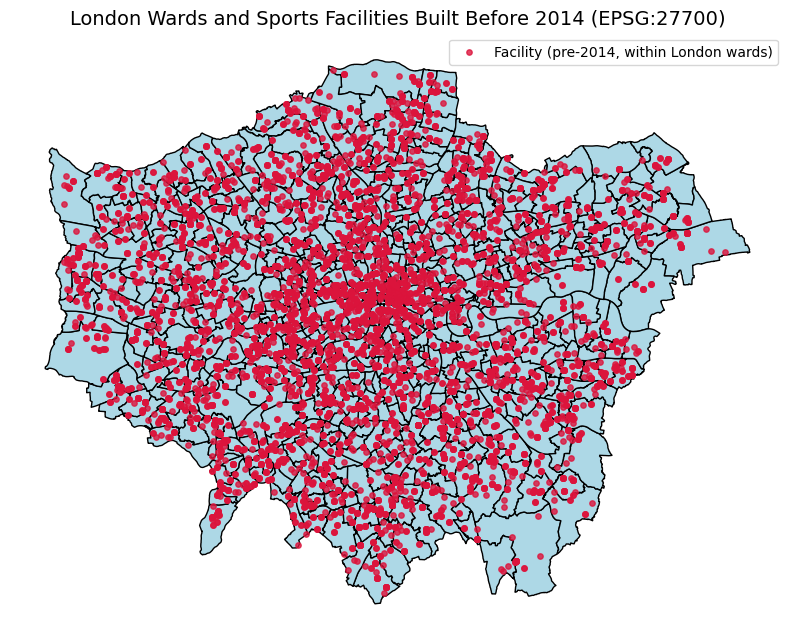

In [20]:
# 3.2.1 Import and caculate Facilities data
facilities = pd.read_csv('data/GIS_Active_Places_Power_Facility_2339094778124018571.csv')  
facilities = facilities.rename(columns={  
    'Accessibility Type Group (Text)': 'access_group',  
    'Management Type Group (Text)': 'mgmt_group',  
    'Facility Type': 'facility_type',  
    'Year Built': 'year_built',  
    'Closed Date': 'closed_date',  
    'Latitude': 'lat',  
    'Longitude': 'lon'  
})  

# Select relevant columns  
facilities = facilities[['lat', 'lon', 'year_built', 'access_group', 'mgmt_group', 'facility_type', 'closed_date']]  

# Type conversion for filtering  
facilities['year_built'] = pd.to_numeric(facilities['year_built'], errors='coerce')  
facilities['closed_date'] = pd.to_datetime(facilities['closed_date'], errors='coerce')  

# Filter: built before 2014 and (not closed or closed in/after 2014)  
mask = (facilities['year_built'] < 2014) & (  
    facilities['closed_date'].isna() | (facilities['closed_date'].dt.year >= 2014)  
)  
facilities = facilities[mask]  

# Convert to GeoDataFrame (WGS84)  
geometry = [Point(xy) for xy in zip(facilities['lon'], facilities['lat'])]  
gdf_fac = gpd.GeoDataFrame(facilities, geometry=geometry, crs="EPSG:4326")  

# Reproject to EPSG:27700 to match wards  
gdf_fac = gdf_fac.to_crs(epsg=27700)  

# Clip facility points to London wards boundary (keep only points within wards)  
gdf_fac_london = gpd.sjoin(gdf_fac, wards, predicate='within', how='inner')  

# Plot: overlay points on wards map  
fig, ax = plt.subplots(figsize=(10, 10))  
wards.plot(ax=ax, color="lightblue", edgecolor="black")  
gdf_fac_london.plot(  
    ax=ax, color="crimson", markersize=15, label="Facility (pre-2014, within London wards)", alpha=0.8  
)  
ax.set_title("London Wards and Sports Facilities Built Before 2014 (EPSG:27700)", fontsize=14)  
ax.axis('off')  
plt.legend()  
plt.show()  

1. Facilities were filtered to include only those operational before 2014 by considering their opening and closing dates. Population estimates for wards each year were taken from the Office for National Statistics ([ONS, 2023](#ons-pop)). Facility density per 10,000 population was calculated using the formula:  

   <div align="center">  
   Facility density = (Number of operational facilities in ward / Ward population) × 10,000  
   </div>  

   This calculation standardises facility counts by population size, enabling meaningful comparison across wards with differing population numbers.  

In [28]:
#3.2.2 Caculate Facilities per 10000 pop by wards
years = range(2010, 2015)  
pop_years = [2011, 2012, 2013, 2014]  
facility_types = ['Education', 'Commercial', 'Local Authority']  # 可按实际表格类型增减  

ward_cols = ['NAME', 'GSS_CODE',  'BOROUGH', 'geometry']  
wards_fac_count = wards[ward_cols].copy()  

# ---- Step 1: Count active facilities per ward per year and by mgmt_group ----  
for yr in years:  
    # Only keep facilities open in the given year  
    mask_active = (  
        (gdf_fac_london['year_built'] <= yr) &  
        (gdf_fac_london['closed_date'].isna() | (gdf_fac_london['closed_date'].dt.year >= yr))  
    )  
    active = gdf_fac_london[mask_active]  

    # Group and count each facility type separately  
    for ftype in facility_types:  
        temp = active[active['mgmt_group'] == ftype]  
        by_ward = temp.groupby('GSS_CODE').size().rename(f'facility_{ftype.lower()}_{yr}').reset_index()  
        wards_fac_count = wards_fac_count.merge(by_ward, on='GSS_CODE', how='left')  
    # Optional: Also count total facilities for each year if you need it  
    # by_ward_total = active.groupby('GSS_CODE').size().rename(f'facility_total_{yr}').reset_index()  
    # wards_fac_count = wards_fac_count.merge(by_ward_total, on='GSS_CODE', how='left')  

# Fill missing with 0  
for ftype in facility_types:  
    for yr in years:  
        col = f'facility_{ftype.lower()}_{yr}'  
        if col in wards_fac_count.columns:  
            wards_fac_count[col] = wards_fac_count[col].fillna(0)  

# ---- Step 2: Read and prepare population data for each year (2011-2014) ----  
pop_files = [  
    'data/London_Population_wards/mid_2011_ward_2011_quinary.csv',  
    'data/London_Population_wards/SAPE20DT8-mid-2012-ward-2017-syoa-estimates-unformatted.csv',  
    'data/London_Population_wards/SAPE20DT8-mid-2013-ward-2017-syoa-estimates-unformatted.csv',  
    'data/London_Population_wards/SAPE20DT8-mid-2014-ward-2017-syoa-estimates-unformatted.csv'  
]  

pop_dfs = []  
for file, year in zip(pop_files, pop_years):  
    df = pd.read_csv(file, low_memory=False)  
    col_map = {'Ward Code': 'GSS_CODE', 'All Ages': f'pop_{year}'}  
    df = df[list(col_map.keys())].rename(columns=col_map)  
    df[f'pop_{year}'] = pd.to_numeric(df[f'pop_{year}'].astype(str).str.replace(',', ''), errors='coerce')  
    pop_dfs.append(df)  
df_pop = reduce(lambda left, right: pd.merge(left, right, on='GSS_CODE', how='outer'), pop_dfs)  

# ---- Step 3: Merge population into wards/facilities table ----  
wards_fac_pop = wards_fac_count.merge(df_pop, on='GSS_CODE', how='left')  

# ---- Step 4: Calculate per 10,000 population facility rate for each type and year ----  
for idx, yr in enumerate(pop_years):  
    for ftype in facility_types:  
        fac_col = f'facility_{ftype.lower()}_{yr}'  
        wards_fac_pop[f'facility_{ftype.lower()}_per_10000pop_{yr}'] = (  
            wards_fac_pop[fac_col] / wards_fac_pop[f'pop_{yr}'] * 10000  
        )  

# ---- Step 5: Only keep per 10,000 columns + ward info, remove raw counts & pop ----  
to_keep = ward_cols.copy()  
for yr in pop_years:  
    for ftype in facility_types:  
        to_keep.append(f'facility_{ftype.lower()}_per_10000pop_{yr}')  
wards_fac_pop = wards_fac_pop[to_keep]  

# ---- Step 6: Display preview ----  
print(wards_fac_pop.head())  

                     NAME   GSS_CODE               BOROUGH  \
0       Chessington South  E05000405  Kingston upon Thames   
1  Tolworth and Hook Rise  E05000414  Kingston upon Thames   
2              Berrylands  E05000401  Kingston upon Thames   
3               Alexandra  E05000400  Kingston upon Thames   
4                Beverley  E05000402  Kingston upon Thames   

                                            geometry  \
0  POLYGON ((516401.6 160201.8, 516407.3 160210.5...   
1  POLYGON ((517829.6 165447.1, 517837.1 165469.4...   
2  POLYGON ((518107.5 167303.4, 518114.3 167307.5...   
3  POLYGON ((520480 166909.8, 520490.7 166901.9, ...   
4  POLYGON ((522071 168144.9, 522063.9 168144, 52...   

   facility_education_per_10000pop_2011  \
0                              3.903963   
1                              4.061738   
2                              0.000000   
3                              8.636511   
4                              0.000000   

   facility_commercial_per_1000

In [27]:
# 3.3 Import Obseity data
# 1. Read childhood obesity CSV, skipping first 2 rows
df_obesity = pd.read_csv('data/Childhood_obesity_2008-09_2013-14.csv', skiprows=2)  

# 2. Clean and clarify column names for age and survey period  
rename_dict = {  
    'New Code': 'GSS_CODE',  
    'Borough': 'BOROUGH',  
    'Names': 'NAME',  
    # Reception (age 4-5)  
    '2008/09 to 2010/11: % obese':  'obese_recp_2008_2011',  
    '2009/10 to 2011/12: % obese':  'obese_recp_2009_2012',  
    '2010/11 to 2012/13: % obese':  'obese_recp_2010_2013',  
    '2011/12 to 2013/14: % obese':  'obese_recp_2011_2014',  
    # Year 6 (age 10-11)  
    '2008/09 to 2010/11: % obese.1': 'obese_y6_2008_2011',  
    '2009/10 to 2011/12: % obese.1': 'obese_y6_2009_2012',  
    '2010/11 to 2012/13: % obese.1': 'obese_y6_2010_2013',  
    '2011/12 to 2013/14: % obese.1': 'obese_y6_2011_2014',  
}  
df_obesity = df_obesity.rename(columns=rename_dict)  

# 3. Only keep relevant columns  
keep_cols = ['GSS_CODE', 'BOROUGH', 'NAME',  
             'obese_recp_2008_2011', 'obese_recp_2009_2012',   
             'obese_recp_2010_2013', 'obese_recp_2011_2014',  
             'obese_y6_2008_2011', 'obese_y6_2009_2012',  
             'obese_y6_2010_2013', 'obese_y6_2011_2014']  
df_obesity = df_obesity[keep_cols]  

# 4. Convert percentage columns to numeric (handles 'n/a' as NaN)  
for col in keep_cols[3:]:  
    df_obesity[col] = pd.to_numeric(df_obesity[col], errors='coerce')  

# 5. Choose target columns from main (facility/population) DataFrame  
final_fac_cols = [  
    'NAME', 'GSS_CODE', 'BOROUGH', 'geometry',  
    'facility_education_per_10000pop_2011', 'facility_education_per_10000pop_2012',  
    'facility_education_per_10000pop_2013', 'facility_education_per_10000pop_2014',  
    'facility_commercial_per_10000pop_2011', 'facility_commercial_per_10000pop_2012',  
    'facility_commercial_per_10000pop_2013', 'facility_commercial_per_10000pop_2014',  
    'facility_local authority_per_10000pop_2011', 'facility_local authority_per_10000pop_2012',  
    'facility_local authority_per_10000pop_2013', 'facility_local authority_per_10000pop_2014'  
]  
# 6. Merge with main DataFrame to create a master table  
wards_master_df = wards_fac_pop[final_fac_cols].merge(  
    df_obesity, on=['GSS_CODE', 'BOROUGH', 'NAME'], how='left'  
)  

In [25]:
#3.4 Import Uemp, green space, ptal data
# Read unemployment data and convert to numeric  
unemp = pd.read_csv("data/out-of-work-family-2010_2014.csv", skiprows=1, usecols=["New Code", "2010", "2011", "2012", "2013", "2014"])  
unemp = unemp.rename(columns={col: f"unemp_{col}" for col in unemp.columns if col != "New Code"})  
unemp = unemp.rename(columns={"New Code": "GSS_CODE"})  
unemp[unemp.columns[1:]] = unemp[unemp.columns[1:]].apply(pd.to_numeric, errors='coerce')  

# Read greenspace and PTAL data  
df_green_ptal = pd.read_csv("data/wards_greenspace_2010_2014.csv", skiprows=1)  

# Extract and process greenspace data  
df_green = df_green_ptal[["New Code", "2012", "2014"]].rename(columns={  
    "New Code": "GSS_CODE", "2012": "greenspace_pct_2012", "2014": "greenspace_pct_2014"  
})  
df_green[["greenspace_pct_2012", "greenspace_pct_2014"]] = df_green[["greenspace_pct_2012", "greenspace_pct_2014"]].apply(pd.to_numeric, errors='coerce')  

# Extract and process PTAL data  
ptal_years = df_green_ptal.columns[df_green_ptal.columns.get_loc("2012")+2:df_green_ptal.columns.get_loc("2012")+6]  
df_ptal = df_green_ptal[["New Code"] + list(ptal_years)].rename(columns={  
    "New Code": "GSS_CODE",   
    ptal_years[0]: "ptal_2010",   
    ptal_years[1]: "ptal_2011",   
    ptal_years[2]: "ptal_2012",   
    ptal_years[3]: "ptal_2014"  
})  
df_ptal[["ptal_2010", "ptal_2011", "ptal_2012", "ptal_2014"]] = df_ptal[["ptal_2010", "ptal_2011", "ptal_2012", "ptal_2014"]].apply(pd.to_numeric, errors='coerce')  

2. Linear interpolation was applied to address missing years in greenspace and PTAL data. The method assumes that changes between two observed values occur in a steady, linear fashion over time and estimates missing values accordingly by proportionate weighting between neighbouring data points.  

This approach is reliable because environmental variables like greenspace and PTAL typically evolve gradually over short periods, and the brief interpolation spans (one to two years) minimise potential inaccuracies. Linear interpolation is a well-established technique in spatial-temporal data analysis, supported by comprehensive reviews such as [Li et al., 2014](#li-2014).  

In [29]:
# Interpolate missing years  
df_green["greenspace_pct_2011"] = df_green["greenspace_pct_2012"]  
df_green["greenspace_pct_2013"] = (df_green["greenspace_pct_2012"] + df_green["greenspace_pct_2014"]) / 2  
df_ptal["ptal_2013"] = (df_ptal["ptal_2012"] + df_ptal["ptal_2014"]) / 2  


After cleaning and interpolation, all datasets were merged on the standard geographic identifier (ward_code) to produce a comprehensive dataset for analysis.


In [30]:
# Merge data into master DataFrame  
wards_master_df = wards_master_df.merge(unemp, on="GSS_CODE", how="left")  
wards_master_df = wards_master_df.merge(df_green[["GSS_CODE",   
    "greenspace_pct_2011", "greenspace_pct_2012", "greenspace_pct_2013", "greenspace_pct_2014"]],   
    on="GSS_CODE", how="left")  
wards_master_df = wards_master_df.merge(df_ptal[["GSS_CODE",   
    "ptal_2010", "ptal_2011", "ptal_2012", "ptal_2013", "ptal_2014"]],   
    on="GSS_CODE", how="left")  
# Preview merged result  
print(wards_master_df.info()) 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 38 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   NAME                                        654 non-null    object  
 1   GSS_CODE                                    654 non-null    object  
 2   BOROUGH                                     654 non-null    object  
 3   geometry                                    654 non-null    geometry
 4   facility_education_per_10000pop_2011        570 non-null    float64 
 5   facility_education_per_10000pop_2012        637 non-null    float64 
 6   facility_education_per_10000pop_2013        637 non-null    float64 
 7   facility_education_per_10000pop_2014        637 non-null    float64 
 8   facility_commercial_per_10000pop_2011       570 non-null    float64 
 9   facility_commercial_per_10000pop_2012       637 non-null    float64 

## Methodology

[[ go back to the top ]](#Table-of-contents)

*[Note: a flow chart that describes the methodology is strongly encouraged - see the example below. This flow chart can be made using Microsoft powerpoint or visio or other software]*

Source: see [link](https://linkinghub.elsevier.com/retrieve/pii/S2210670722004437).

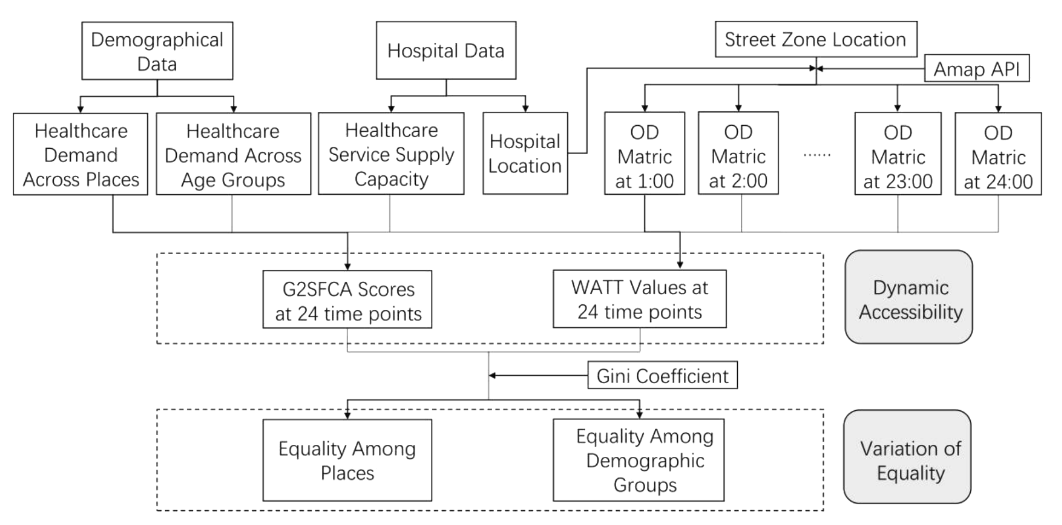

## Results and discussion

[[ go back to the top ]](#Table-of-contents)

## Conclusion

[[ go back to the top ]](#Table-of-contents)

## References

[[ go back to the top ]](#Table-of-contents)

- <a id="ayala-2021"></a>Ayala, G.X., et al., 2021. The social environment and childhood obesity. *International Journal of Environmental Research and Public Health*. Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8365653/ [Accessed 20 Apr 2025].  

- <a id="danielli-2021"></a>Danielli, A., Parker, L. and Swinburn, B., 2021. Systematic review into city interventions to address obesity. *International Journal of Environmental Research and Public Health*, 18(12). Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7910670/ [Accessed 20 Apr 2025].  

- <a id="lieb-2009"></a>Lieb, D.C., 2009. Socioeconomic Factors in the Development of Childhood Obesity. *Current Obesity Reports*. Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5596457/ [Accessed 20 Apr 2025].  

- <a id="phe-2023"></a>Public Health England, 2023. London’s Local Health Profiles. London: Public Health England. Available at: https://fingertips.phe.org.uk/profile/health-profiles/data#page/4/gid/8000073/pat/15/par/E92000001/ati/6/are/E12000007/iid/90323/age/201/sex/4/cat/-1/ctp/-1/yrr/1/cid/4/tbm/1/page-options/car-do-0_tre-ao-0 [Accessed 20 Apr 2025].  

- <a id="titis-2023"></a>Titis, E., 2023. Socio-economic correlates of childhood obesity in urban and rural England. *Public Health Nutrition*. Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10478054/ [Accessed 20 Apr 2025].  

- <a id="wyszynska-2020"></a>Wyszyńska, J., et al., 2020. Physical Activity in the Prevention of Childhood Obesity. *Frontiers in Pediatrics*. Available at: https://www.frontiersin.org/articles/10.3389/fped.2020.535705/full [Accessed 20 Apr 2025].  

- <a id="yuan-2024"></a>Yuan, Y., 2024. Public health interventions against childhood obesity in China and globally. *Preventive Medicine Reports*, 29. Available at: https://www.sciencedirect.com/science/article/pii/S2468266724002457 [Accessed 20 Apr 2025].

- London Data Store (2011). *Statistical GIS Boundary Files for London*. Available at: [https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london) (Accessed: 16 April 2025). <a name="lds-boundary"></a>

- London Data Store (2023). *Ward Profiles and Atlas*. Available at: [https://data.london.gov.uk/dataset/ward-profiles-and-atlas](https://data.london.gov.uk/dataset/ward-profiles-and-atlas) (Accessed: 16 April 2025). <a name="ward-profiles-atlas"></a>

- Office for National Statistics (ONS) (2023). *Ward Level Mid Year Population Estimates (Experimental)*. Available at: [https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/wardlevelmidyearpopulationestimatesexperimental](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/wardlevelmidyearpopulationestimatesexperimental) (Accessed: 16 April 2025). <a name="ons-pop"></a>

- Active Places Power (2023). *Active Places Dataset*. Available at: [https://www.activeplacespower.com/datasets/1e189022e7064e0e9b1bdaadef6d3b78/explore](https://www.activeplacespower.com/datasets/1e189022e7064e0e9b1bdaadef6d3b78/explore) (Accessed: 16 April 2025). <a name="active-places-power"></a>

- Li, J., Heap, A. D., Potter, A., & Daniell, J. (2014). Spatial interpolation methods applied in the environmental sciences: A review. *Environmental Modelling & Software*, 53, pp.182–190. https://doi.org/10.1016/j.envsoft.2013.12.008 <a name="li-2014"></a>  

In [13]:
class HideCodePreprocessor(Preprocessor):  
    """  
    Preprocessor to hide code or output based on cell metadata.  
    
    Usage in notebook:  
    - Add metadata to cell:   
      {"tags": ["hide-code"]} or {"tags": ["hide-output"]}  
    """  
    def preprocess_cell(self, cell, resources, index):  
        # Check cell metadata for hiding instructions  
        tags = cell.metadata.get('tags', [])  
        
        if 'hide-code' in tags and cell.cell_type == 'code':  
            # Add class to hide code  
            cell.cell_type = 'markdown'  
            cell.source = ''  
        
        if 'hide-output' in tags and cell.cell_type == 'code':  
            # Clear outputs for this cell  
            cell.outputs = []  
            cell.metadata['hide_output'] = True  
        
        return cell, resources  

def convert_notebook_to_pdf(  
    notebook_path,   
    output_path=None,   
    hide_code_tags=['hide-code'],  
    hide_output_tags=['hide-output']  
):  
    """  
    Convert Jupyter Notebook to PDF with advanced hiding capabilities.  
    
    Args:  
        notebook_path (str): Path to the notebook file  
        output_path (str, optional): Custom output PDF path  
        hide_code_tags (list): Tags to identify cells with code to hide  
        hide_output_tags (list): Tags to identify cells with output to hide  
    
    Returns:  
        str: Path to the generated PDF file  
    """  
    # Set default output path  
    if output_path is None:  
        output_path = notebook_path.replace('.ipynb', '.pdf')  
    
    # Custom CSS with hiding capabilities  
    css_content = '''  
    @page {  
        size: A4;  
        margin: 2cm 1cm 2cm 1cm;  
    }  
    
    body {  
        font-family: Arial, sans-serif;  
        line-height: 1.6;  
        width: 100%;  
        max-width: 680px;  
        margin: 0 0 0 -80px;  
        padding: 20px;  
    }  
    
    .rendered_html {  
        width: 100%;  
        margin: 0;  
        padding: 0;  
    }  
    
    pre {  
        background-color: #f4f4f4;  
        padding: 10px;  
        margin: 10px 0;  
        overflow-x: auto;  
    }  
    
    table {  
        width: 100%;  
        border-collapse: collapse;  
        margin: 10px 0;  
    }  
    
    code {  
        background-color: #f1f1f1;  
        padding: 2px 4px;  
        border-radius: 3px;  
        display: inline-block;  
    }  
    
    /* Hide code block */  
    .hidden-code,  
    .hidden-code pre,  
    .input_area.hidden-code {  
        display: none !important;  
        visibility: hidden;  
        height: 0;  
        width: 0;  
        overflow: hidden;  
    }  
    
    /* Hide output block */  
    .hidden-output,  
    .output_area.hidden-output,  
    .output_area .hidden-output {  
        display: none !important;  
        visibility: hidden;  
        height: 0;  
        width: 0;  
        overflow: hidden;  
    }  
    '''  
    
    # Write CSS to file  
    with open('notebook_pdf.css', 'w', encoding='utf-8') as f:  
        f.write(css_content)  
    
    # Configure HTML exporter with custom preprocessor  
    html_exporter = HTMLExporter()  
    html_exporter.template_name = 'classic'  
    html_exporter.register_preprocessor(HideCodePreprocessor, enabled=True)  
    
    # Export notebook to HTML  
    body, _ = html_exporter.from_filename(notebook_path)  
    
    # Generate temporary HTML file  
    html_path = notebook_path.replace('.ipynb', '.html')  
    with open(html_path, 'w', encoding='utf-8') as f:  
        f.write(body)  
    
    # Convert HTML to PDF  
    HTML(html_path).write_pdf(  
        output_path,   
        stylesheets=['notebook_pdf.css']  
    )  
    
    print(f"✅ PDF conversion successful: {output_path}")  
    return output_path  

# Usage example  
convert_notebook_to_pdf('24109799_submission_CASA0006.ipynb')  

✅ PDF conversion successful: 24109799_submission_CASA0006.pdf


'24109799_submission_CASA0006.pdf'